# Cleaning Modes With Rational Filters

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.ticker import MultipleLocator
from gwpy.timeseries import TimeSeries
import astropy.units as u

In [4]:
from tqdm.notebook import tqdm
import ringdown as rd

## PE results

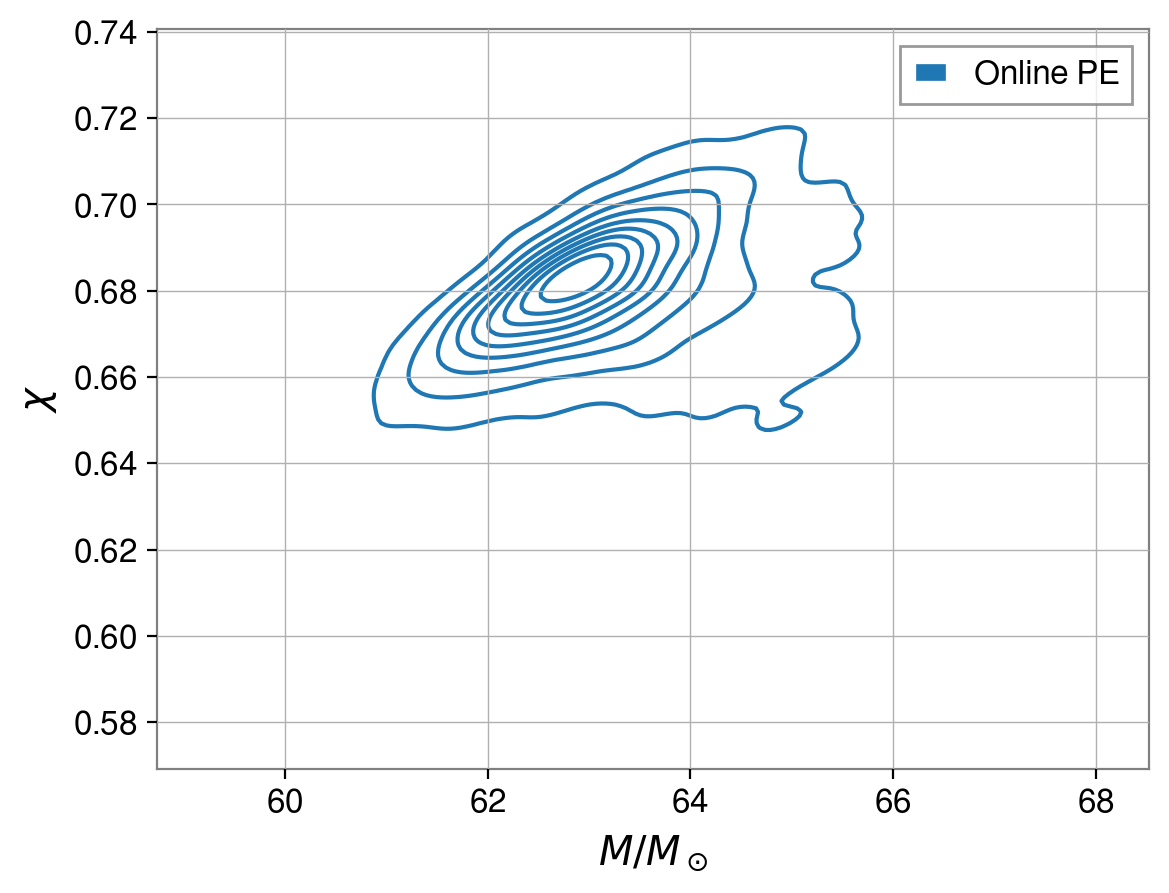

In [5]:
pe = np.genfromtxt('online_pesummary.dat', names=True)
l, = pl.plot([], [], label='Online PE')
sns.kdeplot(x=pe['final_mass'], y=pe['final_spin'], color=l.get_color())
pl.xlabel(r'$M / M_\odot$')
pl.ylabel(r'$\chi$')
pl.legend()

In [6]:
pe_fs = {}
pe_gammas = {}
with tqdm(total=28) as pbar:
    for l in [2,3]:
        for m in range(0, l+1):
            for n in [0,1,2,3]:
                fs = []
                gammas = []
                for s in pe:
                    f,t = rd.qnms.get_ftau(s['final_mass'], s['final_spin'], l=l, m=m, n=n)
                    fs.append(f)
                    gammas.append(1/t)
                pe_fs[(l,m,n)] = np.array(fs)
                pe_gammas[(l,m,n)] = np.array(gammas)

                pbar.update(1)

  0%|          | 0/28 [00:00<?, ?it/s]

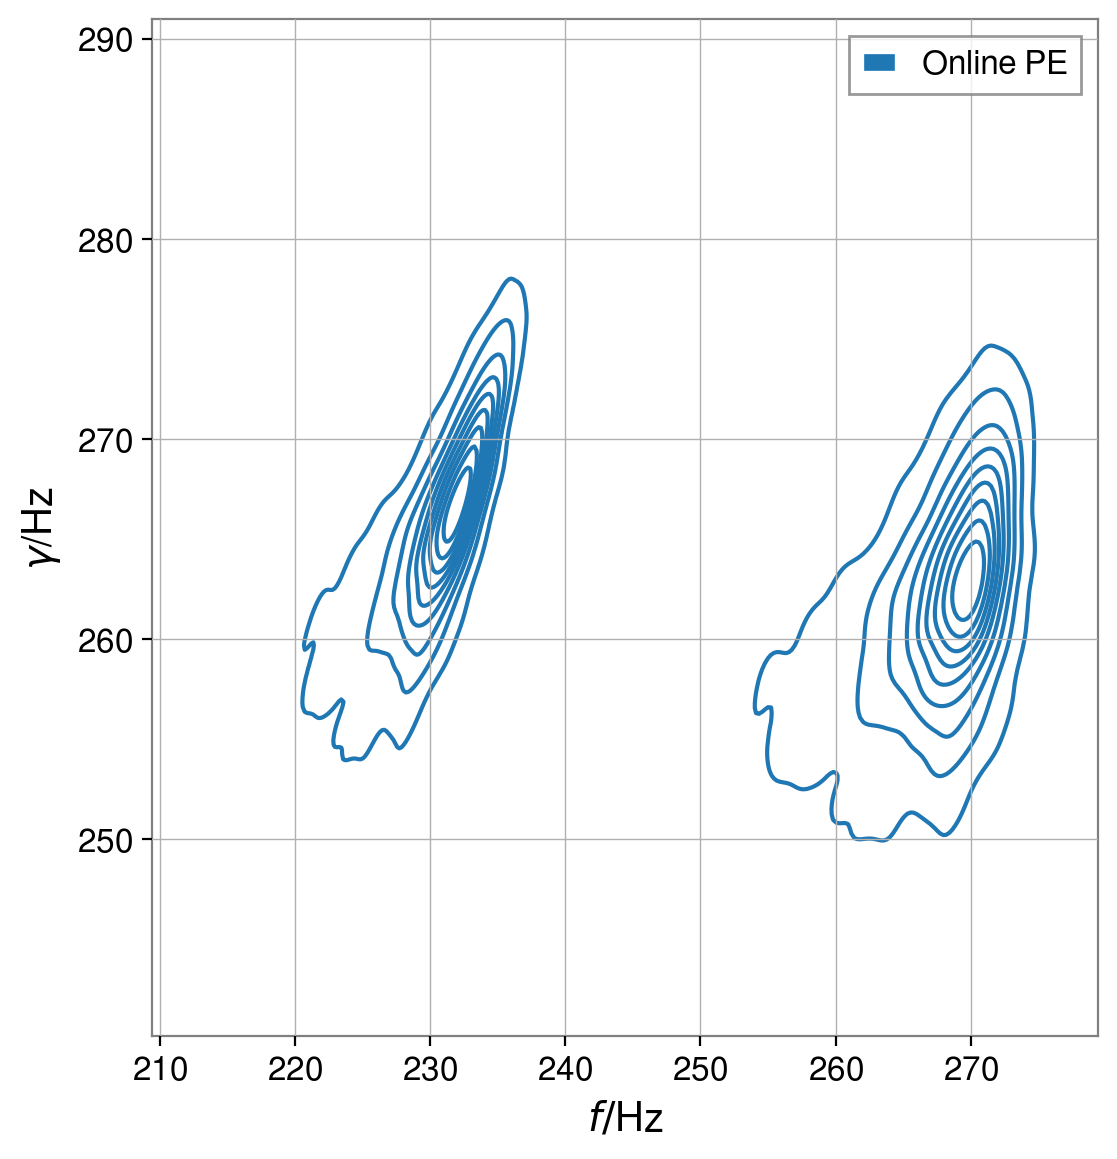

In [66]:
l, = pl.plot([], [], label='Online PE')
sns.kdeplot(x=pe_fs[(2,2,0)], y=pe_gammas[(2,2,0)], color=l.get_color())
sns.kdeplot(x=pe_fs[(2,1,0)], y=pe_gammas[(2,1,0)], color=l.get_color())
pl.xlabel(r'$f/$Hz')
pl.ylabel(r'$\gamma$/Hz')
pl.legend()

In [12]:
data = TimeSeries.read('L-L1_G429267_llhoft-1376089749.0-14.gwf', 'L1:GDS-CALIB_STRAIN_CLEAN')
times_list = [float(i/u.s) for i in data.times]
# has 14s of data sampled at 16K

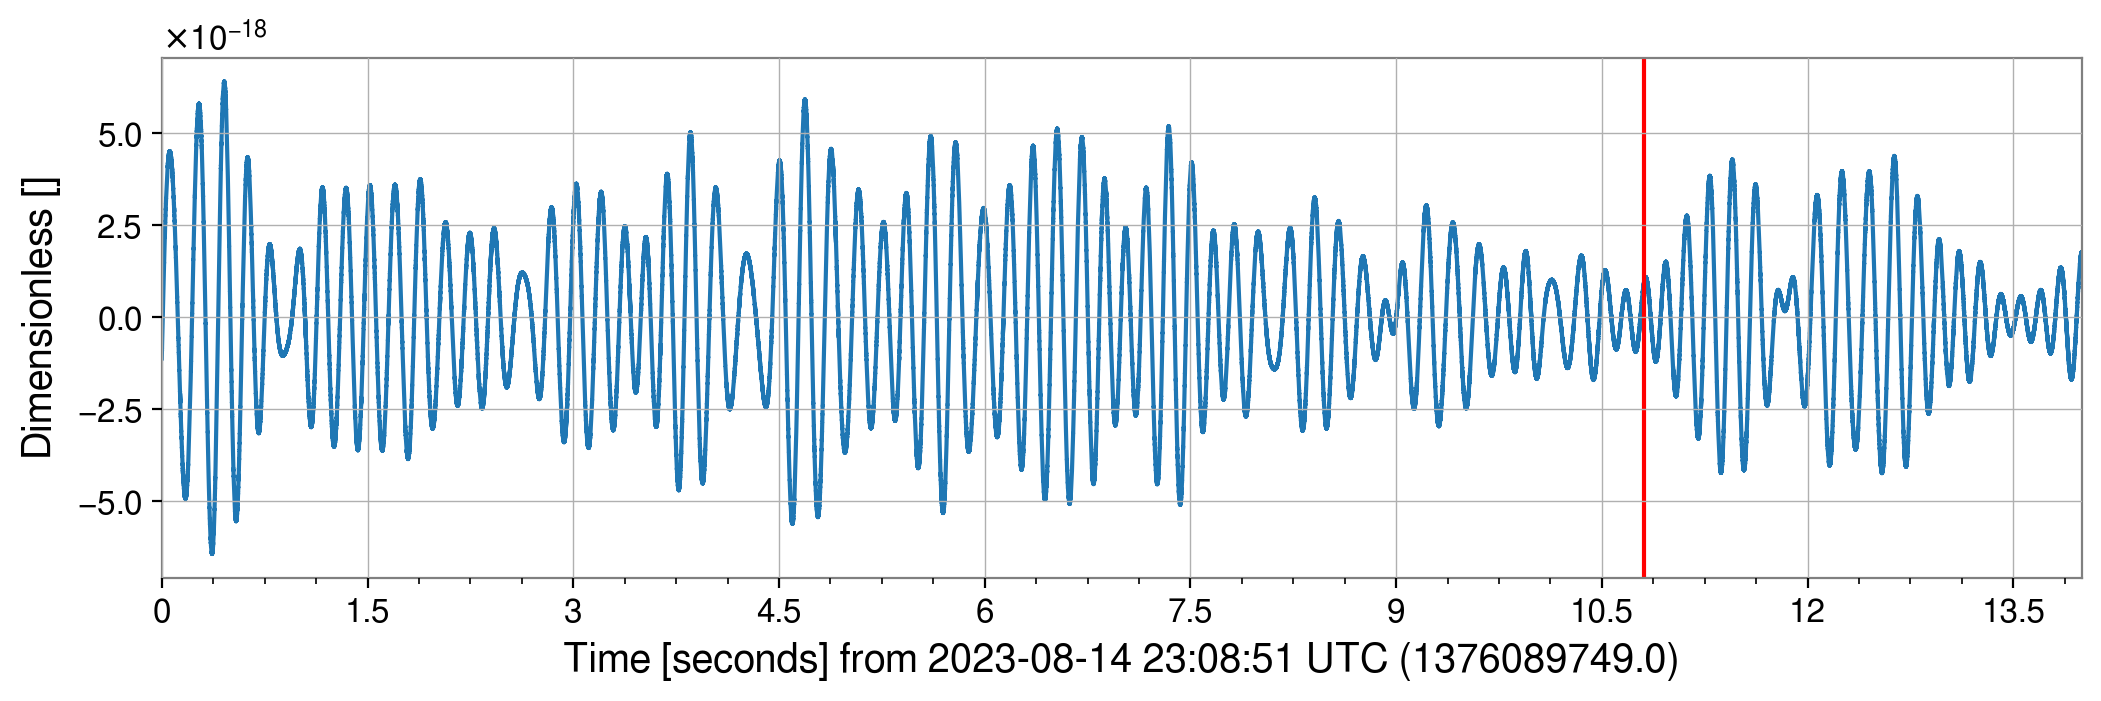

In [13]:
t_ref = 1376089759.81
data.plot()
pl.axvline(t_ref, c = 'r')

(1e-24, 1e-19)

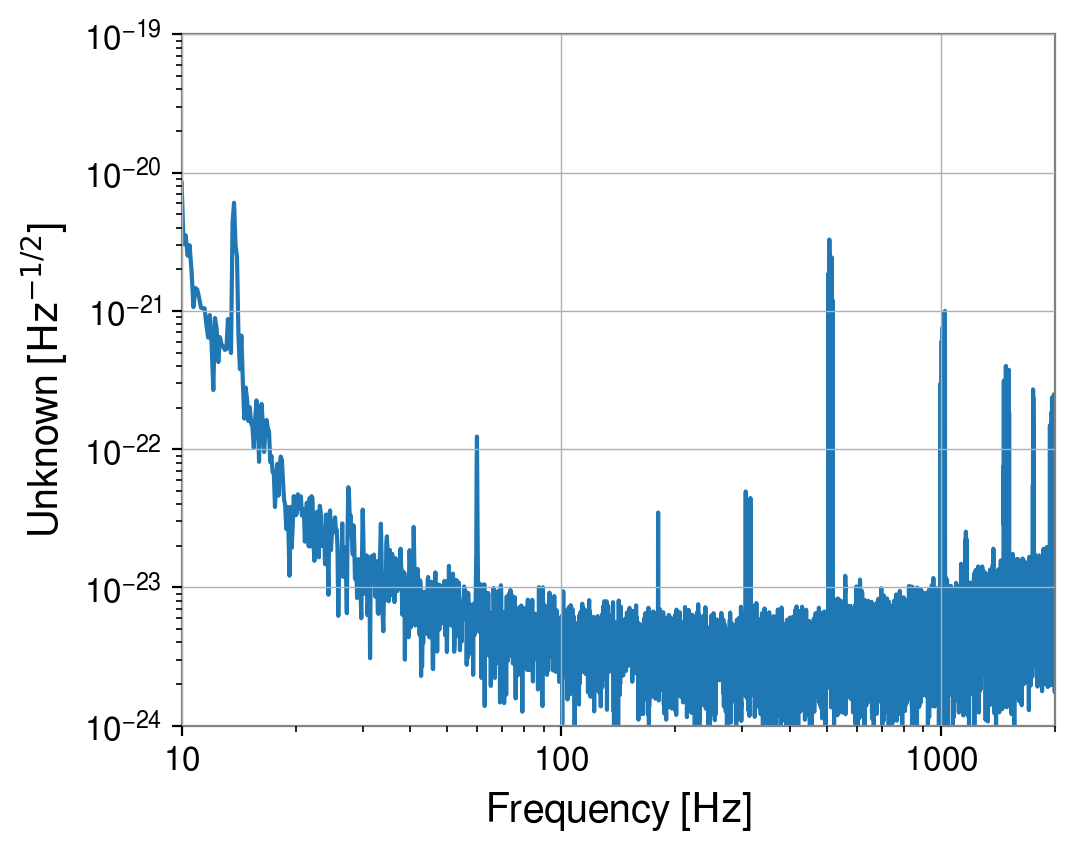

In [14]:
data.asd(fftlength = 8).plot()
pl.xlim(10,2000)
pl.ylim(1e-24, 1e-19)

(1376089759.61, 1376089759.9099998)

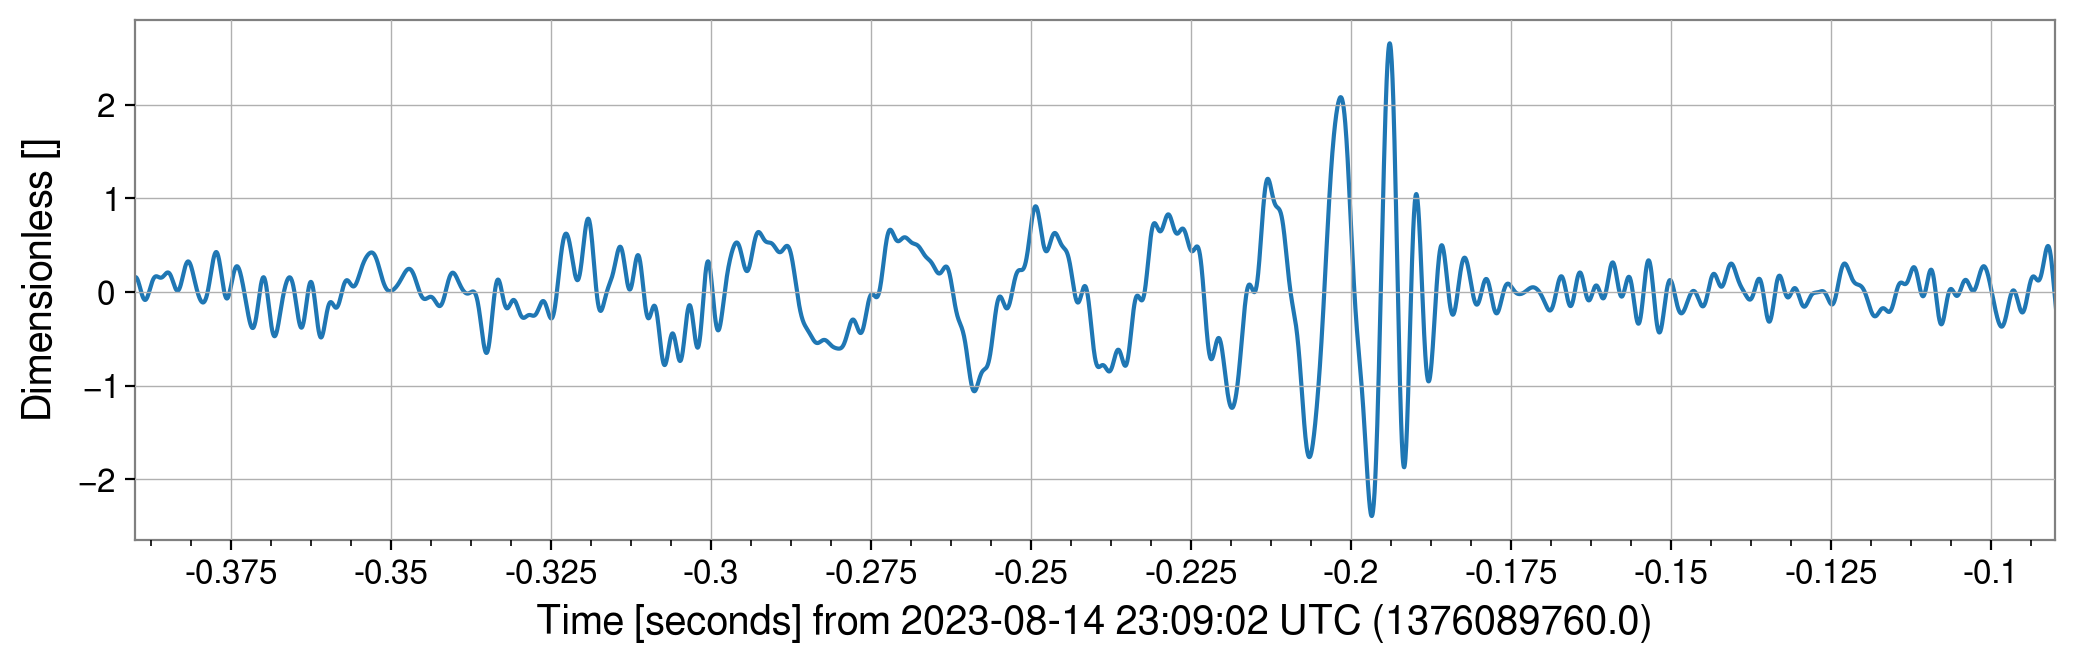

In [15]:
# -- Whiten and bandpass data
white_data = data.whiten()
bp_data = white_data.bandpass(30, 400)
fig3 = bp_data.plot()
pl.xlim(t_ref-0.2, t_ref+0.1)

In [16]:
t_0 = float(bp_data.times[np.argmax(bp_data.value)]/u.s)

In [17]:
t_0

1376089759.8060913

Download data

Set some parameters of GW150914

In [128]:
IMR = [63.06, 0.68]
mass_unit = qnm_filter.Filter.mass_unit(IMR[0]) 
time_offset = 0 # in units of mass

input = dict(model_list = [(2, 2, 0, 'p'),(2,2,1,'p'), (2,1,0,'p')], #l, m, n, prograde/retrograde
             # trucation time (geocenter, in second)
             t_init = t_0+time_offset*mass_unit, #event time from https://gracedb.ligo.org/superevents/S230814ah/view/
             # length of the analysis segment (in second)
             segment_length = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 4096,
             # sky localization
             ra = None, dec = None,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)
output_str = ''
for item in input['model_list']:
    output_str += f"{item[0]}{item[1]}{item[2]}+"
filter_str = output_str.rstrip('+')

fit = qnm_filter.Network(**input)

Load data

In [129]:
fit.original_data['L1'] = qnm_filter.RealData(data.value, index = times_list)

Perform time alignment across detectors

In [130]:
fit.detector_alignment()

Condition data 

In [131]:
fit.condition_data('original_data', trim = 0.05, **input)

Cholesky-decomposition of the covariance matrix 

In [132]:
fit.compute_acfs('original_data')
fit.cholesky_decomposition()

## Likelihood as a function of mass and spin

Sampling remnant mass and spin

In [133]:
delta_mass = 2.0
delta_chi = 0.05
massspace = np.arange(30, 100, delta_mass)
chispace = np.arange(0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

Interate over the samplings

In [134]:
fit.first_index()
likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = -1, **input)
credible_region = qnm_filter.find_credible_region(likelihood_data)

In [135]:
projected_mass, projected_chi = qnm_filter.project_to_1d(likelihood_data, delta_mass, delta_chi)

In [136]:
test = abs(np.subtract(likelihood_data, credible_region))
index = test<0.5

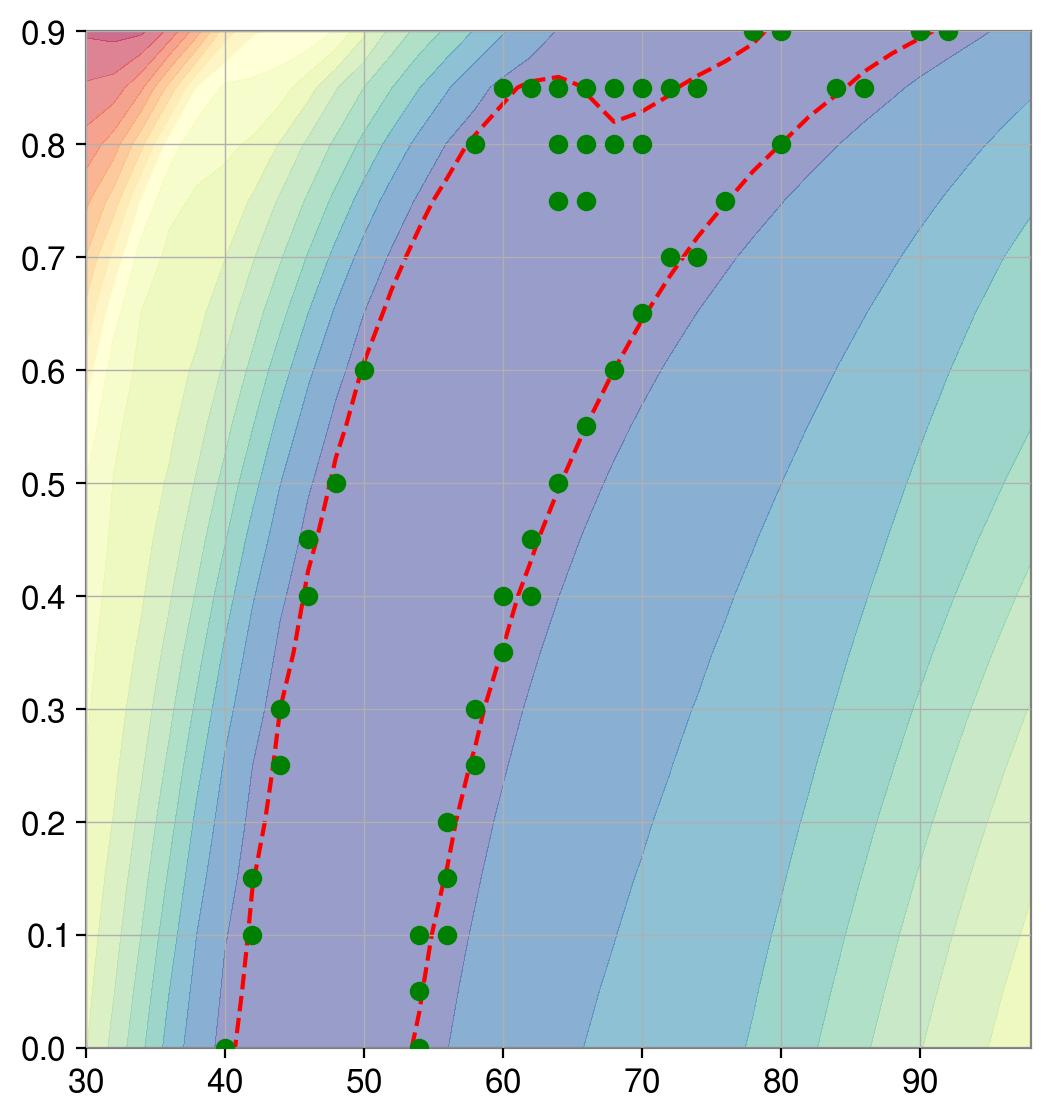

In [137]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
points = ax.scatter(mass_grid[index], chi_grid[index], color='g', label='Highlighted Points', zorder=5)

In [138]:
coordinates = list(zip(mass_grid[index], chi_grid[index]))

In [139]:
rd.qnms.get_ftau(coordinates[0][0], coordinates[0][1], l=2,m=2,n=0)

(301.8566847456739, 0.002214641553516204)

In [140]:
import qnm
import astropy.constants as c
T_MSUN = c.M_sun.value * c.G.value / c.c.value**3

freq220_arr = []
gamma220_arr = []

freq221_arr = []
gamma221_arr = []

for i in coordinates:
    mode_info = rd.qnms.get_ftau(i[0], i[1], l=2,m=2,n=0)
    freq220_arr.append(mode_info[0])
    gamma220_arr.append(1/mode_info[1])
    
for i in coordinates:
    mode_info = rd.qnms.get_ftau(i[0], i[1], l=2,m=2,n=1)
    freq221_arr.append(mode_info[0])
    gamma221_arr.append(1/mode_info[1])

In [143]:
freq210_arr = []
gamma210_arr = []
for i in coordinates:
    mode_info = rd.qnms.get_ftau(i[0], i[1], l=2,m=1,n=0)
    freq210_arr.append(mode_info[0])
    gamma210_arr.append(1/mode_info[1])

/home/neil/anaconda3/envs/ringdown/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(
/home/neil/anaconda3/envs/ringdown/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(
/home/neil/anaconda3/envs/ringdown/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(


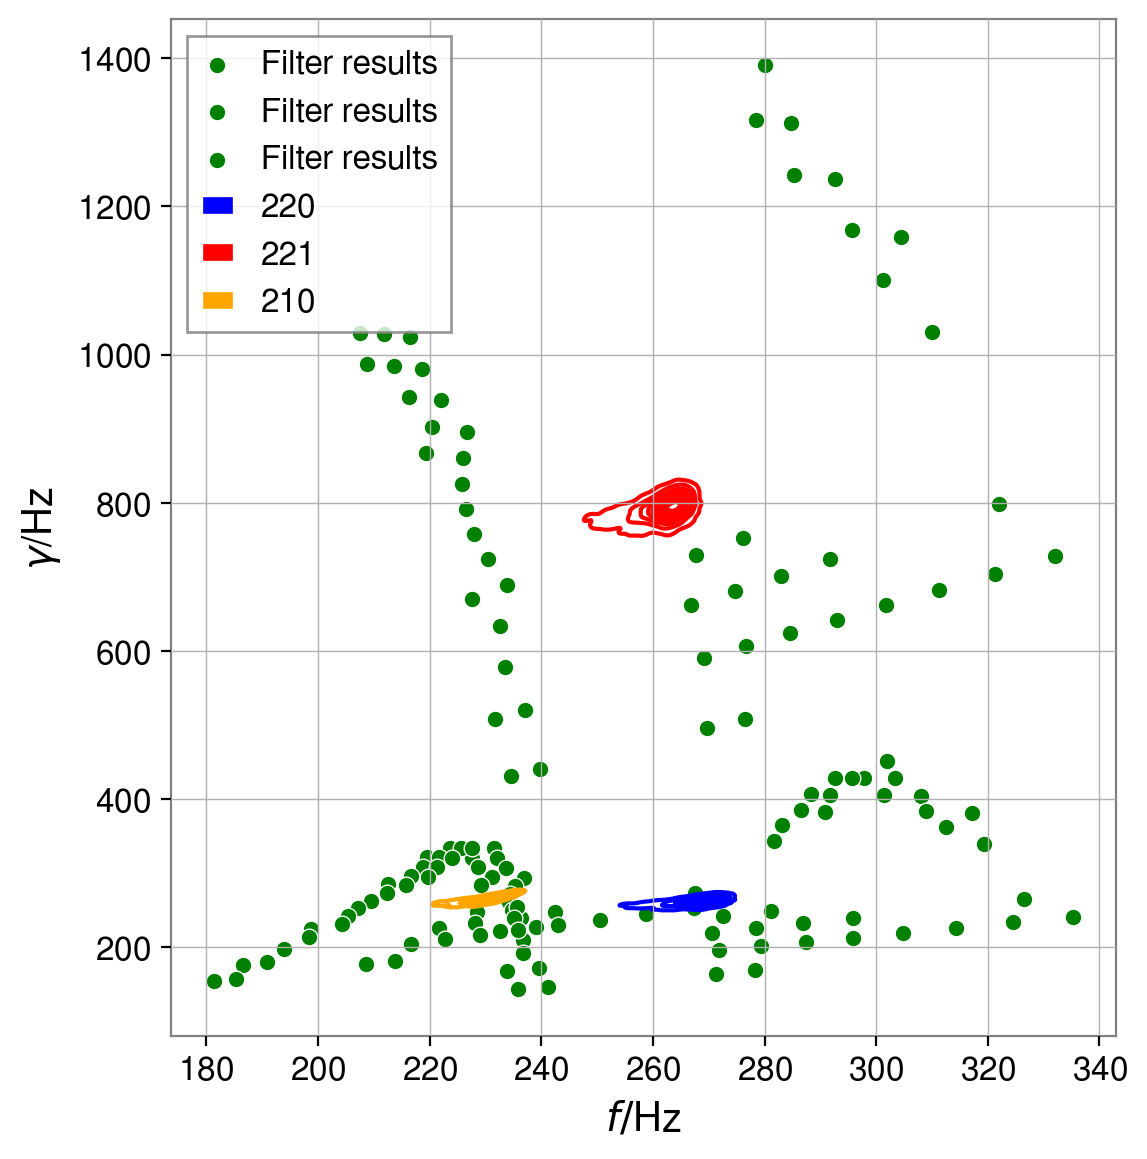

In [144]:
sns.kdeplot(x=pe_fs[(2,2,0)], y=pe_gammas[(2,2,0)], c='blue')
sns.kdeplot(x=pe_fs[(2,1,0)], y=pe_gammas[(2,1,0)], c='orange')
sns.kdeplot(x=pe_fs[(2,2,1)], y=pe_gammas[(2,2,1)], c='r')
sns.scatterplot(x=freq220_arr, y=gamma220_arr, c='g', label='Filter results')
sns.scatterplot(x=freq221_arr, y=gamma221_arr, c='g', label='Filter results')
sns.scatterplot(x=freq210_arr, y=gamma210_arr, c='g', label='Filter results')
l, = pl.plot([], [], c='blue', label='220')
l, = pl.plot([], [], c='r', label='221')
l, = pl.plot([], [], c='orange', label='210')
pl.xlabel(r'$f/$Hz')
pl.ylabel(r'$\gamma$/Hz')
pl.legend()

Plot 2d contours

In [ ]:
IMR_analysis = [63.06, 0.68, [[1.23], [1.8]], [[0.02], [0.02]]]

In [ ]:
IMR_analysis[2]

In [ ]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.errorbar(x=IMR_analysis[0], y=IMR_analysis[1], xerr=IMR_analysis[2], yerr=IMR_analysis[3], 
           c='g', label='IMR')
ax.plot(np.NaN, np.NaN, '-', color='none', label='ln(Evidence) = %.1F' % evidence)


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)
pl.legend(loc = 'lower right')

ax.set_title('S230814 \n $t_{init}$ + ' + str(time_offset) +
             r'$M_\odot$, filters = ' + filter_str)
# pl.savefig('./gif_imgs/220+1_t={}M.png'.format(time_offset))

In [83]:
temp = contours.levels

In [87]:
temp

array([-480., -475., -470., -465., -460., -455., -450., -445.,
       -440., -435., -430., -425., -420., -415., -410., -405.,
       -400., -395., -390., -385., -380., -375.])

In [32]:
np.max(likelihood_data)

-377.2068142582487

In [91]:
'results/gif_imgs/{}_t={}M.png'.format(filter_str, time_offset)

'results/gif_imgs/220+221_t=4M.png'

Text(0.5, 1.0, 'S230814 \n $t_{init}$ + 4$M_\\odot$, filters = 220+221')

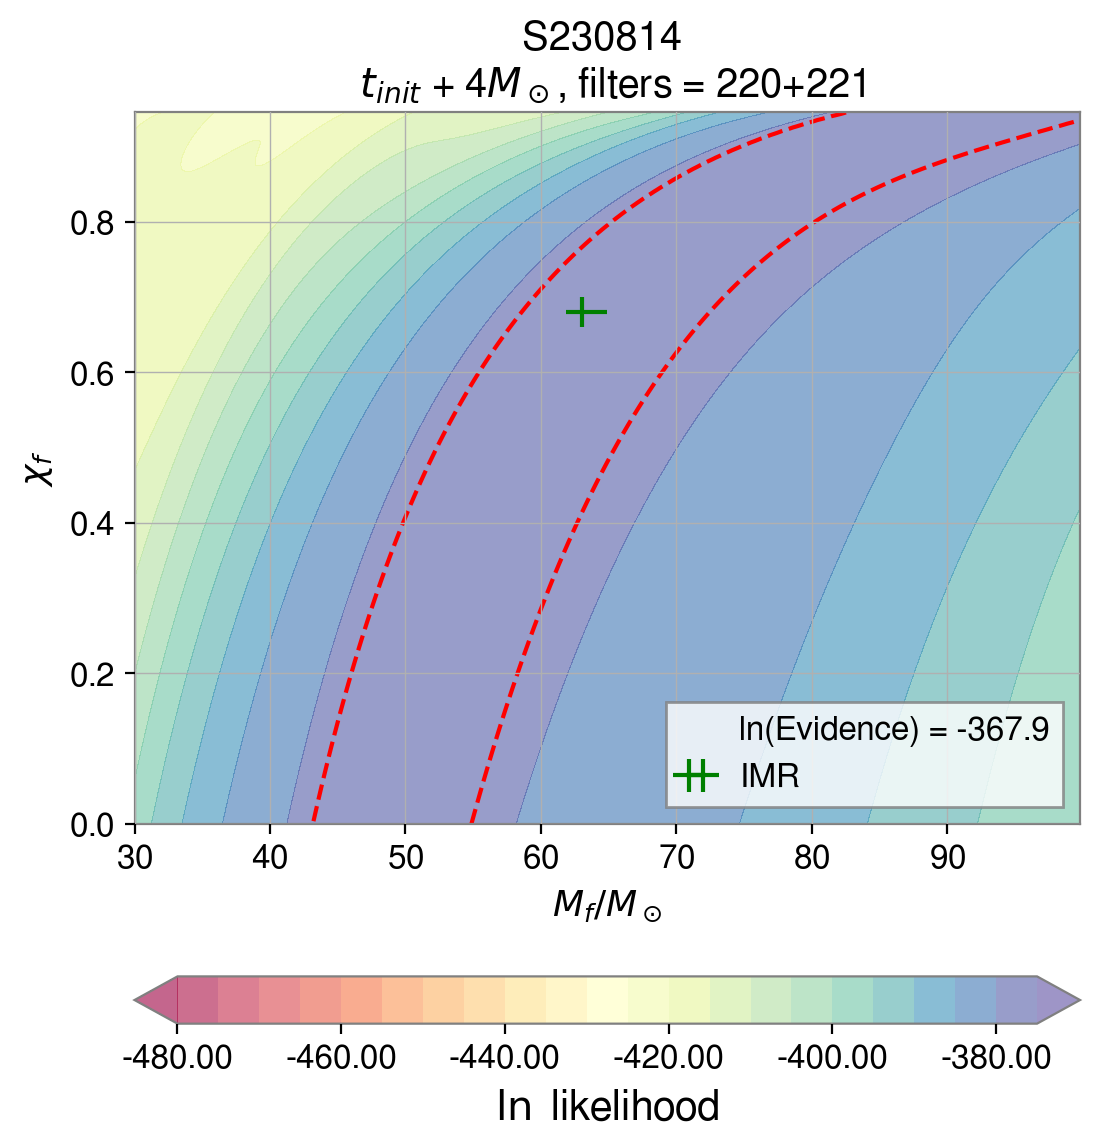

In [82]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, levels = temp, extend = 'both', cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.errorbar(x=IMR_analysis[0], y=IMR_analysis[1], xerr=IMR_analysis[2], yerr=IMR_analysis[3], 
           c='g', label='IMR')
ax.plot(np.NaN, np.NaN, '-', color='none', label='ln(Evidence) = %.1F' % evidence)


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(temp[::4])

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)
pl.legend(loc = 'lower right')

ax.set_title('S230814 \n $t_{init}$ + ' + str(time_offset) +
             r'$M_\odot$, filters = ' + filter_str)
# pl.savefig('./gif_imgs/220+1_t={}M.png'.format(time_offset))

## Checking SNR

In [18]:
template = fit.truncate_data(fit.original_data)['L1']

In [19]:
fit.compute_SNR(None, template, 'L1', optimal = True)

31.590262905704403

## Making gif images

In [ ]:
input = dict(model_list = [(2, 2, 0, 'p'),(2,2,1,'p')], #l, m, n, prograde/retrograde
             # trucation time (geocenter, in second)
             t_init = t_0+time_offset*mass_unit, #event time from https://gracedb.ligo.org/superevents/S230814ah/view/
             # length of the analysis segment (in second)
             segment_length = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 4096,
             # sky localization
             ra = None, dec = None, #no idea, literally eyeballed off the sky map
             # lower limit of the high-pass filter (in Hz)
             flow = 20)
output_str = ''
for item in input['model_list']:
    output_str += f"{item[0]}{item[1]}{item[2]}+"
filter_str = output_str.rstrip('+')

In [105]:
# Only changes the times, don't forget to change the files names
# if you go back and change the filters
offset_arr = range(3)
levels_arr = []

max_arr = []
evidence_arr = []
credible_arr = []

for i in offset_arr:
    time_offset = i
    input['t_init'] = t_0+time_offset*mass_unit
    fit = qnm_filter.Network(**input)
    fit.original_data['L1'] = qnm_filter.RealData(data.value, index = times_list)
    fit.detector_alignment()
    fit.condition_data('original_data', trim = 0.05, **input)
    fit.compute_acfs('original_data')
    fit.cholesky_decomposition()
    delta_mass = 2.0
    delta_chi = 0.03
    massspace = np.arange(30, 100, delta_mass)
    chispace = np.arange(0., 0.95, delta_chi)
    mass_grid, chi_grid = np.meshgrid(massspace, chispace)
    fit.first_index()
    likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = -1, **input)
    credible_region = qnm_filter.find_credible_region(likelihood_data)
    
    max_arr.append(np.max(likelihood_data))
    evidence_arr.append(evidence)
    credible_arr.append(credible_region)
    
    #Determining levels
    contours = ax.contourf(mass_grid, chi_grid, likelihood_data, temp, cmap='Spectral', extend = "both",
                       origin='lower', alpha=0.6, linestyles='--')
    levels_arr.append(contours.levels)

    #plotting
    pl.rc('figure', figsize=(6.1, 6.6))
    fig, ax = pl.subplots()
    contours = ax.contourf(mass_grid, chi_grid, likelihood_data, levels = levels_arr[0], extend = "both",
                           cmap='Spectral', origin='lower', alpha=0.6, linestyles='--')
    dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                       linestyles ='--')
    ax.errorbar(x=IMR_analysis[0], y=IMR_analysis[1], xerr=IMR_analysis[2], yerr=IMR_analysis[3], 
               c='g', label='IMR')
    ax.plot(np.NaN, np.NaN, '-', color='none', label='ln(Evidence) = %.1F' % evidence)


    # coloarbar
    cbar=fig.colorbar(contours, orientation="horizontal", 
                      pad=0.15, format='%3.2f')
    cbar.set_label(r'$\ln$ likelihood', fontsize=15)
#     cbar.set_ticks(color_levels)

    pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
    pl.ylabel(r'$\chi_f$', fontsize=13)
    pl.legend(loc = 'lower right')

    ax.set_title('S230814 \n $t_{init}$ + ' + str(time_offset) +
                 r'$M_\odot$, filters = ' + filter_str)
    pl.savefig('./gif_imgs/220_t={}M.png'.format(time_offset))
    pl.close()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create sample data
x = np.linspace(0, 5, 100)
y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(X) + np.cos(Y)

# Create the original heatmap
plt.contourf(X, Y, Z, cmap='viridis')
plt.colorbar()  # Add a colorbar for reference
plt.title('Original Heatmap')
plt.show()

# Extract contour levels from the original heatmap
contour_levels = plt.contour(X, Y, Z).levels

# Create a new heatmap with consistent color levels
new_data = np.random.rand(100, 100)  # Replace with your new data
plt.contourf(X, Y, new_data, levels=contour_levels, cmap='viridis')
plt.colorbar()  # Add a colorbar for reference
plt.title('New Heatmap with Consistent Color Levels')
plt.show()
